In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# pip install facenet_pytorch

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from facenet_pytorch import MTCNN
import facenet_pytorch as fp
import sklearn
import kagglehub
import random
from tqdm import tqdm

In [4]:
print(f"OS version: {os.name}")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-Learn version: {sklearn.__version__}")
print(f"Kagglehub version: {kagglehub.__version__}")


OS version: posix
OpenCV version: 4.11.0
NumPy version: 1.26.4
Pandas version: 2.2.3
PyTorch version: 2.2.2+cu121
TorchVision version: 0.17.2+cu121
Matplotlib version: 3.7.5
Scikit-Learn version: 1.2.2
Kagglehub version: 0.3.11


In [5]:
# Download dataset
path = kagglehub.dataset_download("sanikatiwarekar/deep-fake-detection-dfd-entire-original-dataset")
REAL_VIDEOS_PATH = os.path.join(path, "DFD_original sequences")
FAKE_VIDEOS_PATH = os.path.join(path, "DFD_manipulated_sequences/DFD_manipulated_sequences")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# MTCNN detector
detector = MTCNN(keep_all=True, device=DEVICE)


In [7]:
# Stratified train/val/test split (70% train, 15% val, 15% test)

from sklearn.utils import shuffle

# Limit dataset to 40 videos (20 real + 20 fake for balance)
SAMPLE_SIZE = 1000
NUM_REAL = SAMPLE_SIZE // 2
NUM_FAKE = SAMPLE_SIZE - NUM_REAL

# Shuffle and pick balanced subset
real_videos = [f for f in os.listdir(REAL_VIDEOS_PATH) if f.endswith('.mp4')]
fake_videos = [f for f in os.listdir(FAKE_VIDEOS_PATH) if f.endswith('.mp4')]

real_videos = shuffle(real_videos, random_state=42)[:NUM_REAL]
fake_videos = shuffle(fake_videos, random_state=42)[:NUM_FAKE]

real_paths = [os.path.join(REAL_VIDEOS_PATH, f) for f in real_videos]
fake_paths = [os.path.join(FAKE_VIDEOS_PATH, f) for f in fake_videos]

video_paths = real_paths + fake_paths
video_labels = [0] * len(real_paths) + [1] * len(fake_paths)


train_videos, test_videos, y_train, y_test = train_test_split(
    video_paths, video_labels, test_size=0.15, stratify=video_labels, random_state=42
)
train_videos, val_videos, y_train, y_val = train_test_split(
    train_videos, y_train, test_size=0.15 / 0.85, stratify=y_train, random_state=42
)

print(f"Train videos: {len(train_videos)}")
print(f"Val videos: {len(val_videos)}")
print(f"Test videos: {len(test_videos)}")

Train videos: 603
Val videos: 130
Test videos: 130


In [8]:
# Extract faces into specific folders
def extract_faces_from_video(video_path, output_dir, label, frame_skip=10, max_faces=10):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    count = 0
    frame_num = 0
    while cap.isOpened() and count < max_faces:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % frame_skip == 0:
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_frame = Image.fromarray(rgb_frame)
            faces = detector(pil_frame)
            if faces is not None:
                if isinstance(faces, torch.Tensor) and faces.ndim == 4:
                    faces = [f for f in faces]
                for face_tensor in faces:
                    if face_tensor is None or not isinstance(face_tensor, torch.Tensor):
                        continue
                    try:
                        face_img = (face_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                        if face_img.shape[0] < 10 or face_img.shape[1] < 10:
                            continue
                        face_img = cv2.resize(face_img, (224, 224))
                        save_path = os.path.join(output_dir, f"{label}_{count}.jpg")
                        cv2.imwrite(save_path, cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR))
                        count += 1
                    except Exception as e:
                        print(f"[ERROR] Skipping face due to processing error: {e}")
                        continue
                    if count >= max_faces:
                        break
        frame_num += 1
    cap.release()
    
splits = {'train': train_videos, 'val': val_videos, 'test': test_videos}
for split, videos in splits.items():
    print(f"Processing {split} set: {len(videos)} videos")
    for video_path in tqdm(videos, desc=f"{split} videos"):
        label = 'real' if 'DFD_original' in video_path else 'fake'
        vidname = os.path.splitext(os.path.basename(video_path))[0]
        output_dir = f'processed_faces/{split}/{label}/{vidname}'
        os.makedirs(output_dir, exist_ok=True)
        extract_faces_from_video(video_path, output_dir, label)

Processing train set: 603 videos


train videos: 100%|██████████| 603/603 [13:28<00:00,  1.34s/it]


Processing val set: 130 videos


val videos: 100%|██████████| 130/130 [02:55<00:00,  1.35s/it]


Processing test set: 130 videos


test videos: 100%|██████████| 130/130 [02:52<00:00,  1.32s/it]


In [9]:
# Directory format 
'''
processed_faces/
├── train/
│   ├── real/
│   │   └── abc/  → abc_0.jpg, abc_1.jpg, ...
│   └── fake/
│       └── xyz/
├── val/
│   └── ...
└── test/
    └── ...

'''


'\nprocessed_faces/\n├── train/\n│   ├── real/\n│   │   └── abc/  → abc_0.jpg, abc_1.jpg, ...\n│   └── fake/\n│       └── xyz/\n├── val/\n│   └── ...\n└── test/\n    └── ...\n\n'

In [10]:
def load_images_and_labels(split):
    image_paths, labels = [], []
    for label in ['real', 'fake']:
        base = f'processed_faces/{split}/{label}'
        if not os.path.exists(base): continue
        for root, _, files in os.walk(base):
            for fname in files:
                if fname.endswith('.jpg'):
                    image_paths.append(os.path.join(root, fname))
                    labels.append(0 if label == 'real' else 1)
    return image_paths, labels

X_train, y_train = load_images_and_labels('train')
X_val, y_val = load_images_and_labels('val')
X_test, y_test = load_images_and_labels('test')

In [11]:
# Image gathering 
'''
processed_faces/
├── train/
│   ├── real/
│   │   └── video1/ → real_0.jpg, real_1.jpg, ...
│   └── fake/
│       └── video2/
├── val/
│   └── ...
└── test/
    └── ...
'''


'\nprocessed_faces/\n├── train/\n│   ├── real/\n│   │   └── video1/ → real_0.jpg, real_1.jpg, ...\n│   └── fake/\n│       └── video2/\n├── val/\n│   └── ...\n└── test/\n    └── ...\n'

In [12]:
from torch.utils.data import Dataset
from PIL import Image
import os
import glob
import random

class SequenceFaceDataset(Dataset):
    def __init__(self, base_dir, split='train', sequence_len=10):
        self.sequence_len = sequence_len
        self.samples = []

        for label in ['real', 'fake']:
            folder = os.path.join(base_dir, split, label)
            if not os.path.exists(folder):
                continue
            for video_folder in os.listdir(folder):
                path = os.path.join(folder, video_folder)
                if os.path.isdir(path):
                    frames = sorted(glob.glob(os.path.join(path, '*.jpg')))
                    if len(frames) >= sequence_len:
                        self.samples.append((frames, 0 if label == 'real' else 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        chosen = sorted(random.sample(frame_paths, self.sequence_len))
        frames = []

        for fp in chosen:
            img = Image.open(fp).convert("RGB")
            if label == 0:
                img = train_real_transforms(img)
            else:
                img = train_fake_transforms(img)
            frames.append(img)

        frames = torch.stack(frames)  # [T, 3, 224, 224]
        return frames, torch.tensor(label, dtype=torch.float32)



In [13]:
from torchvision import transforms

# For real images in training
train_real_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# For fake images in training (no strong augmentation, but normalized)
train_fake_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# For validation & test (just resizing and normalization)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])


In [14]:
train_dataset = SequenceFaceDataset('processed_faces', split='train', sequence_len=10)
val_dataset   = SequenceFaceDataset('processed_faces', split='val', sequence_len=10)
test_dataset  = SequenceFaceDataset('processed_faces', split='test', sequence_len=10)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class FusionAttention(nn.Module):
    def __init__(self, input_dims):
        super().__init__()
        self.input_dims = input_dims
        self.projections = nn.ModuleList([
            nn.Linear(dim, 64) for dim in input_dims
        ])
        self.attention = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, features):  # features: list of [B, D]
        projected = [proj(f) for proj, f in zip(self.projections, features)]  # [B, 64]
        stacked = torch.stack(projected, dim=1)  # [B, N, 64]
        attn_weights = F.softmax(self.attention(stacked).squeeze(-1), dim=1)  # [B, N]
        fused = torch.sum(stacked * attn_weights.unsqueeze(-1), dim=1)  # [B, 64]
        return fused

class TemporalTransformer(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, input_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 500, input_dim))  # max 500 frames

    def forward(self, x):  # x: [B, T, D]
        B, T, D = x.shape
        cls_tokens = self.cls_token.expand(B, 1, D)
        x = torch.cat([cls_tokens, x], dim=1)  # [B, T+1, D]
        x = x + self.pos_embedding[:, :T+1, :]
        x = x.permute(1, 0, 2)  # [T+1, B, D]
        x = self.transformer(x)  # [T+1, B, D]
        return x[0]  # [B, D] - CLS token output


In [16]:

class DeepFakeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.vgg = models.vgg19(pretrained=True).features
        self.xcep = models.mobilenet_v2(pretrained=True).features

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fusion = FusionAttention([64, 512, 1280])
        self.temporal_model = TemporalTransformer(input_dim=64)

        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def extract_features(self, x):
        r = self.pool(self.resnet.conv1(x)).flatten(1)  # [B, 64]
        v = self.pool(self.vgg(x)).flatten(1)           # [B, 512]
        xcep = self.pool(self.xcep(x)).flatten(1)       # [B, 1280]
        fused = self.fusion([r, v, xcep])               # [B, 64]
        return fused

    def forward(self, x_seq):  # x_seq: [B, T, 3, 224, 224]
        B, T, C, H, W = x_seq.shape
        x_seq = x_seq.view(B*T, C, H, W)
        features = self.extract_features(x_seq)         # [B*T, 64]
        features = features.view(B, T, -1)              # [B, T, 64]
        temporal_feat = self.temporal_model(features)   # [B, 64]
        out = self.classifier(temporal_feat).squeeze(1)
        return out

model = DeepFakeDetector().to(DEVICE)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [17]:

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Example: Differential learning rates
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-5},
    {'params': model.vgg.parameters(), 'lr': 1e-5},
    {'params': model.xcep.parameters(), 'lr': 1e-5},
    {'params': model.fusion.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-4},
])

In [18]:
# loss_fn = nn.BCELoss()

# Example for weighted loss
real_count = NUM_REAL
fake_count = NUM_FAKE
pos_weight = torch.tensor([real_count / fake_count]).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [19]:
def train(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0, 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
            train_loss += loss.item() * x.size(0)
            train_acc += ((y_pred > 0.5) == y).sum().item()
        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}, Train Acc: {train_acc/len(train_loader.dataset):.4f}, Val Acc: {val_acc:.4f}")
        # Clear memory after evaluation
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

In [20]:
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred = model(x)
            correct += ((y_pred > 0.5) == y).sum().item()
            total += x.size(0)
    return correct / total
    
import torch

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [21]:
train(model, train_loader, val_loader, epochs=10)

Epoch 1, Loss: 0.6117, Train Acc: 0.8982, Val Acc: 1.0000
Epoch 2, Loss: 0.5147, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 3, Loss: 0.4916, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 4, Loss: 0.4826, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 5, Loss: 0.4790, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 6, Loss: 0.4770, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 7, Loss: 0.4760, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 8, Loss: 0.4754, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 9, Loss: 0.4750, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 10, Loss: 0.4747, Train Acc: 1.0000, Val Acc: 1.0000


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# Evaluate and visualize performance
y_true, y_pred, y_probs = [], [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        preds = model(x).cpu().numpy()
        probs = preds.copy()
        preds = preds > 0.5
        y_pred.extend(preds)
        y_probs.extend(probs)
        y_true.extend(y.numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("ROC-AUC:", roc_auc_score(y_true, y_probs))
print("F1 Score:", f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy: 1.0
ROC-AUC: 1.0
F1 Score: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        55
         1.0       1.00      1.00      1.00        74

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



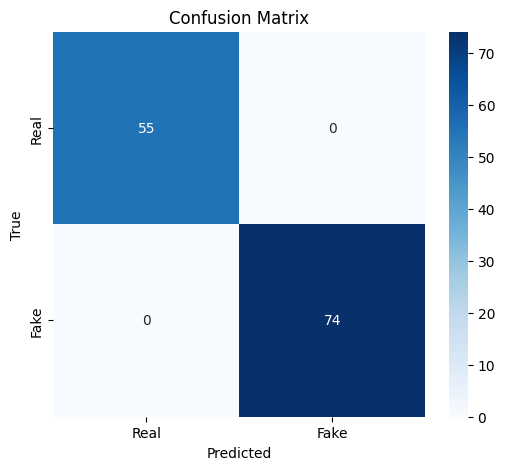

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


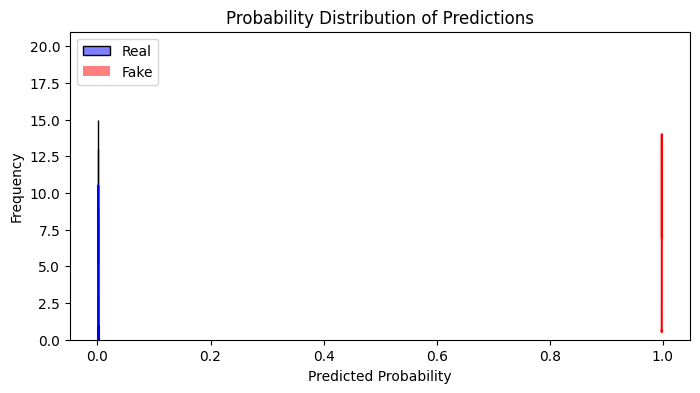

In [25]:
# Probability distribution plot
plt.figure(figsize=(8, 4))
sns.histplot([p for i, p in enumerate(y_probs) if y_true[i] == 0], color='blue', label='Real', kde=True)
sns.histplot([p for i, p in enumerate(y_probs) if y_true[i] == 1], color='red', label='Fake', kde=True)
plt.title("Probability Distribution of Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [26]:
torch.save(model.state_dict(), "Deepfake_Detection_Model.pth")